## Домашняя работа №4. Современные сверточные архитектуры

### Данные

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
import torch
import torchvision as tv
import numpy as np
import time
import os

In [56]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((300, 300)),
    tv.transforms.ToTensor()
])

In [57]:
dataset = {ds: tv.datasets.ImageFolder(
    root=os.path.join('data', ds),
    transform=transforms
) for ds in ['train', 'val']}

In [58]:
dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'val']}
dataset_classes = dataset['train'].classes
print('classes:', dataset_classes, '\nsize', dataset_size)

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


In [59]:
BATCH_SIZE = 8

In [60]:
train = torch.utils.data.DataLoader(dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=True)

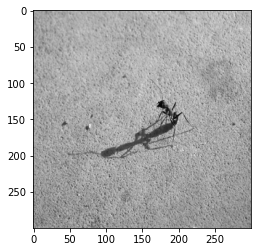

In [61]:
plt.imshow(dataset['train'][4][0][1].numpy(), cmap='gray')

In [62]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

### Задание №1-2

**ResNet 18**

In [93]:
ResNet = tv.models.resnet18(pretrained=False)

In [94]:
ResNet.fc = torch.nn.Sequential(
    torch.nn.Linear(ResNet.fc.in_features, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

In [92]:
def train_model(model, num_epochs, dev):
    model = model.to(dev)

    loss = torch.nn.CrossEntropyLoss()
    trainer = torch.optim.Adam(model.parameters(), lr=0.001)

    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., torch.Tensor([0]).to(dev)
        start=time.time()
        
        model.train()
        for X, y in train:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += y.shape[0]
        
        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., torch.Tensor([0]).to(dev)
        model.eval()
        for X, y in test:
            X, y = X.to(dev), y.to(dev)
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += y.shape[0]
            
        train_acc_res = (train_acc / train_passed)[0].cpu().numpy()
        test_acc_res = (test_acc / test_passed)[0].cpu().numpy()
        print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            ep, time.time() - start, train_loss / train_iters, train_acc_res,
            test_loss / test_iters, test_acc_res)
        )

In [95]:
train_model(ResNet, 10, dev)

ep: 0, taked: 9.765, train_loss: 0.7694174387762623, train_acc: 0.5450819134712219, test_loss: 2.512860673666, test_acc: 0.47058823704719543
ep: 1, taked: 9.259, train_loss: 0.7074350330137438, train_acc: 0.5737704634666443, test_loss: 0.7013164088129997, test_acc: 0.673202633857727
ep: 2, taked: 9.601, train_loss: 0.6814645048110716, train_acc: 0.5860655307769775, test_loss: 1.3813129216432571, test_acc: 0.5816993713378906
ep: 3, taked: 9.615, train_loss: 0.6627900485069521, train_acc: 0.6147540807723999, test_loss: 0.629509262740612, test_acc: 0.6470588445663452
ep: 4, taked: 9.815, train_loss: 0.6441961151938285, train_acc: 0.6639344096183777, test_loss: 0.7800240268115886, test_acc: 0.5620915293693542
ep: 5, taked: 10.250, train_loss: 0.6576552179551893, train_acc: 0.6434425711631775, test_loss: 0.7103141322731972, test_acc: 0.601307213306427
ep: 6, taked: 11.260, train_loss: 0.6427394728506765, train_acc: 0.6311475038528442, test_loss: 0.7055114567279815, test_acc: 0.5686274766921

In [135]:
import gc

# Функция для очистки памяти видеокарты
def free_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [111]:
del ResNet
free_gpu_memory()

**Fine-tuning**

**Вариант №1.** Обучение всех слоев модели

In [98]:
ResNetTuning = tv.models.resnet18(pretrained=True)

In [99]:
ResNetTuning.fc = torch.nn.Sequential(
    torch.nn.Linear(ResNetTuning.fc.in_features, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

In [100]:
train_model(ResNetTuning, 10, dev)

ep: 0, taked: 9.705, train_loss: 0.7217502863176407, train_acc: 0.6270491480827332, test_loss: 1.2361786510795354, test_acc: 0.5816993713378906
ep: 1, taked: 9.648, train_loss: 0.5792320735992924, train_acc: 0.7295081615447998, test_loss: 1.2091005161404609, test_acc: 0.6405228972434998
ep: 2, taked: 10.204, train_loss: 0.7264061877804417, train_acc: 0.5778688192367554, test_loss: 0.8405665427446365, test_acc: 0.5816993713378906
ep: 3, taked: 9.848, train_loss: 0.6748184850139003, train_acc: 0.5901638865470886, test_loss: 0.627371072769165, test_acc: 0.6666666865348816
ep: 4, taked: 9.980, train_loss: 0.6448324601496419, train_acc: 0.6598360538482666, test_loss: 0.7309413507580758, test_acc: 0.6339869499206543
ep: 5, taked: 10.817, train_loss: 0.6734371406416739, train_acc: 0.6229507923126221, test_loss: 0.650677852332592, test_acc: 0.5882353186607361
ep: 6, taked: 11.009, train_loss: 0.6922822825370296, train_acc: 0.561475396156311, test_loss: 0.6670699179172516, test_acc: 0.607843160

In [ ]:
del ResNetTuning
free_gpu_memory()

**Вариант №2.** Обучение только последнего слоя

In [101]:
# С заморозкой
ResNetTuning = tv.models.resnet18(pretrained=True)

for name, param in ResNetTuning.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False

ResNetTuning.fc = torch.nn.Sequential(
    torch.nn.Linear(ResNetTuning.fc.in_features, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

train_model(ResNetTuning, 10, dev)

ep: 0, taked: 6.758, train_loss: 0.47132925160469546, train_acc: 0.8278688192367554, test_loss: 0.3196481884457171, test_acc: 0.9215686321258545
ep: 1, taked: 6.564, train_loss: 0.2981360899584909, train_acc: 0.9057376384735107, test_loss: 0.37815708462148906, test_acc: 0.843137264251709
ep: 2, taked: 6.701, train_loss: 0.2009924047536427, train_acc: 0.9344261884689331, test_loss: 0.3250262056244537, test_acc: 0.915032684803009
ep: 3, taked: 6.988, train_loss: 0.24880218433756981, train_acc: 0.9262294769287109, test_loss: 0.8710392430431966, test_acc: 0.7647058963775635
ep: 4, taked: 6.566, train_loss: 0.17949480877348012, train_acc: 0.9385245442390442, test_loss: 0.301795706039411, test_acc: 0.9215686321258545
ep: 5, taked: 6.608, train_loss: 0.08501985648106183, train_acc: 0.9754098057746887, test_loss: 0.4210856593330391, test_acc: 0.9084967374801636
ep: 6, taked: 7.622, train_loss: 0.08268527982046738, train_acc: 0.9754098057746887, test_loss: 0.37008931478630985, test_acc: 0.90849

**Вывод:** обучение только последнего слоя дает значительный прирост качества модели (около 30%). Это связано с тем, что он хранит более абстрактную информацию, по сравнению с первыми слоями.

In [112]:
del ResNetTuning
free_gpu_memory()

**VGG 16**

In [125]:
VGG = tv.models.vgg16(pretrained=False)

In [ ]:
VGG

In [126]:
VGG.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

In [127]:
train_model(VGG, 10, dev)

ep: 0, taked: 44.872, train_loss: 2.434349477291107, train_acc: 0.4836065173149109, test_loss: 0.6915726244449616, test_acc: 0.5424836874008179
ep: 1, taked: 45.781, train_loss: 0.6935563049008769, train_acc: 0.4590163826942444, test_loss: 0.6931430727243424, test_acc: 0.5424836874008179
ep: 2, taked: 47.102, train_loss: 0.6932716158128553, train_acc: 0.5327868461608887, test_loss: 0.6933123290538787, test_acc: 0.4575163424015045
ep: 3, taked: 47.437, train_loss: 0.6932328651028294, train_acc: 0.4754098057746887, test_loss: 0.6928674787282944, test_acc: 0.5424836874008179
ep: 4, taked: 45.035, train_loss: 0.6931922205032841, train_acc: 0.49180325865745544, test_loss: 0.6931294798851013, test_acc: 0.5424836874008179
ep: 5, taked: 48.630, train_loss: 0.6936685615970243, train_acc: 0.4549179971218109, test_loss: 0.6930236458778382, test_acc: 0.5424836874008179
ep: 6, taked: 48.738, train_loss: 0.6945974672994306, train_acc: 0.5163934230804443, test_loss: 0.6924464732408524, test_acc: 0.54

In [ ]:
del VGG
free_gpu_memory()

**Fine-tuning**

Обучим только последник слой (блок слоев)

In [ ]:
VGG_Tuned = tv.models.vgg16(pretrained=True)

In [ ]:
VGG_Tuned

In [140]:
for name, param in VGG_Tuned.named_parameters():
    n_layer = int(name.split('.')[1])
    if n_layer not in range(24, 29):
        param.requires_grad = False

In [141]:
VGG_Tuned.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

In [142]:
train_model(VGG_Tuned, 5, dev)

ep: 0, taked: 26.009, train_loss: 0.8017165055198054, train_acc: 0.6434425711631775, test_loss: 0.5706412337720395, test_acc: 0.7516340017318726
ep: 1, taked: 23.984, train_loss: 0.6271225917002847, train_acc: 0.737704873085022, test_loss: 0.8844883050769567, test_acc: 0.758169949054718
ep: 2, taked: 25.158, train_loss: 0.3768991495092069, train_acc: 0.8483605980873108, test_loss: 0.25053045409731567, test_acc: 0.9215686321258545
ep: 3, taked: 26.136, train_loss: 0.2783417209997893, train_acc: 0.9057376384735107, test_loss: 0.572078429890098, test_acc: 0.8627451062202454
ep: 4, taked: 25.979, train_loss: 0.3148478716912289, train_acc: 0.8934425711631775, test_loss: 0.3055789378471673, test_acc: 0.8954248428344727


In [143]:
del VGG_Tuned
free_gpu_memory()

### Задание №3

**Аугментация данных**

In [168]:
transforms_train = tv.transforms.Compose([
    tv.transforms.Resize((300, 300)),
    tv.transforms.RandomCrop(244),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor()
])
transforms_test = tv.transforms.Compose([
    tv.transforms.Resize((300, 300)),
    tv.transforms.CenterCrop(244),
    tv.transforms.ToTensor()
])

In [169]:
train_dataset = tv.datasets.ImageFolder(
    root=os.path.join('data', 'train'),
    transform=transforms_train
)
test_dataset = tv.datasets.ImageFolder(
    root=os.path.join('data', 'val'),
    transform=transforms_test
)

In [170]:
BATCH_SIZE = 8

In [171]:
train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

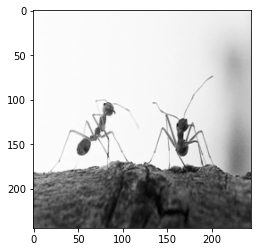

In [172]:
plt.imshow(train_dataset[5][0][1].numpy(), cmap='gray')

In [176]:
# С заморозкой
ResNetTuning = tv.models.resnet18(pretrained=True)

for name, param in ResNetTuning.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False

ResNetTuning.fc = torch.nn.Sequential(
    torch.nn.Linear(ResNetTuning.fc.in_features, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

train_model(ResNetTuning, 10, dev)

ep: 0, taked: 7.708, train_loss: 0.525696293000252, train_acc: 0.7827868461608887, test_loss: 0.2750813801772892, test_acc: 0.9084967374801636
ep: 1, taked: 7.744, train_loss: 0.3246380667532644, train_acc: 0.8770491480827332, test_loss: 0.26639963418710977, test_acc: 0.9019607901573181
ep: 2, taked: 7.473, train_loss: 0.2343669794499874, train_acc: 0.9180327653884888, test_loss: 0.2674350390356267, test_acc: 0.915032684803009
ep: 3, taked: 7.974, train_loss: 0.16266194502672843, train_acc: 0.9221311211585999, test_loss: 0.34000780251808466, test_acc: 0.9019607901573181
ep: 4, taked: 8.440, train_loss: 0.17649400847092753, train_acc: 0.9221311211585999, test_loss: 0.3909571685013361, test_acc: 0.8627451062202454
ep: 5, taked: 8.548, train_loss: 0.29522551055396756, train_acc: 0.8975409269332886, test_loss: 0.4350606420543045, test_acc: 0.8888888955116272
ep: 6, taked: 9.117, train_loss: 0.2037435067637313, train_acc: 0.9508196115493774, test_loss: 0.3153680070419796, test_acc: 0.888888

In [ ]:
del ResNetTuning
free_gpu_memory()

In [174]:
VGG_Tuned = tv.models.vgg16(pretrained=True)

for name, param in VGG_Tuned.named_parameters():
    n_layer = int(name.split('.')[1])
    if n_layer not in range(24, 29):
        param.requires_grad = False

VGG_Tuned.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(100, 2)
)

train_model(VGG_Tuned, 10, dev)

ep: 0, taked: 13.643, train_loss: 0.8958070576190948, train_acc: 0.6926229000091553, test_loss: 0.471348712593317, test_acc: 0.7843137383460999
ep: 1, taked: 13.841, train_loss: 0.685377144525128, train_acc: 0.7336065173149109, test_loss: 0.40729162469506264, test_acc: 0.9084967374801636
ep: 2, taked: 13.927, train_loss: 0.6995892541392916, train_acc: 0.7254098057746887, test_loss: 0.5797514274716378, test_acc: 0.7385621070861816
ep: 3, taked: 14.638, train_loss: 0.5149645068712773, train_acc: 0.8155737519264221, test_loss: 0.44376473464071753, test_acc: 0.8627451062202454
ep: 4, taked: 14.179, train_loss: 0.47623106572897206, train_acc: 0.8278688192367554, test_loss: 0.7017737606540322, test_acc: 0.8954248428344727
ep: 5, taked: 15.195, train_loss: 0.6414080249040478, train_acc: 0.8811475038528442, test_loss: 1.0996568821719848, test_acc: 0.8104575276374817
ep: 6, taked: 15.488, train_loss: 0.4214562326669693, train_acc: 0.8073769807815552, test_loss: 2.2006241425870825, test_acc: 0.6

**Вывод:** аугментация данных на модель ResNet практически не повлияла, а качество модели VGG ухудшилось. Вероятно, это связано с особенностями работы моделей.\
**Общий вывод:** наилучшее качество показали модели в пункте 2, и использованием fine-tuning. Возможно, аугментация данных привела бы к лучшим результатам, но для этого нужен больший набор данных.